# **Regressiemodellen in Machine Learning (supervised)**

## **Bibliotheken importeren**

In [112]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


## **Data inlezen**

**connectie**

In [113]:
go_sales_con = sqlite3.connect('Great_Outdoors_Data_SQLite\go_sales.sqlite')
go_crm_con = sqlite3.connect('Great_Outdoors_Data_SQLite\go_crm.sqlite')
go_staff_con = sqlite3.connect('Great_Outdoors_Data_SQLite\go_staff.sqlite')
go_inv_con = 'Great_Outdoors_Data_SQLite\GO_SALES_INVENTORY_LEVELSData.csv'
go_forecast_con = 'Great_Outdoors_Data_SQLite\GO_SALES_PRODUCT_FORECASTData.csv'

**Dataframes inlezen**

In [114]:
Go_staff_queries = {
    'Course': 'SELECT * FROM Course',
    'Training': 'SELECT * FROM Training',
    'Sales_staff': 'SELECT * FROM Sales_staff',
    'Satisfaction': 'SELECT * FROM Satisfaction',
    'Satisfaction_type': 'SELECT * FROM Satisfaction_type',
}

Go_crm_queries = {
    'Retailer_contact': 'SELECT * FROM Retailer_contact',
    'Retailer_site' : 'SELECT * FROM Retailer_site',
    'Retailer' : 'SELECT * FROM Retailer',
    'Retailer_type' : 'SELECT * FROM Retailer_type',
    'COUNTRY': 'SELECT * FROM COUNTRY',
    'Sales_territory': 'SELECT * FROM Sales_territory'
}

Go_sales_queries = {
    'Order_method': 'SELECT * FROM Order_method',
    'Order_header': 'SELECT * FROM Order_header',
    'Order_details': 'SELECT * FROM Order_details',
    'Returned_item': 'SELECT * FROM Returned_item',
    'Return_reason': 'SELECT * FROM Return_reason',
    'Product': 'SELECT * FROM Product',
    'PRODUCT_TYPE': 'SELECT * FROM PRODUCT_TYPE',
    'PRODUCT_LINE' : 'SELECT * FROM PRODUCT_LINE',
    'Sales_TARGETData' : 'SELECT * FROM Sales_TARGETData',
    'Sales_branch': 'SELECT * FROM Sales_branch'
}


dataframes = {}

# Lees elke tabel in een DataFrame
for table_name, query in Go_staff_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, go_staff_con)

for table_name, query in Go_crm_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, go_crm_con)

for table_name, query in Go_sales_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, go_sales_con)

# Lees de CSV-bestanden in pandas DataFrames
GO_SALES_INVENTORY_LEVELSData = pd.read_csv(go_inv_con, index_col=False)
GO_SALES_PRODUCT_FORECASTData = pd.read_csv(go_forecast_con, index_col=False)

# Voeg de DataFrames toe aan de dataframes dictionary
dataframes['GO_SALES_INVENTORY_LEVELSData'] = GO_SALES_INVENTORY_LEVELSData
dataframes['GO_SALES_PRODUCT_FORECASTData'] = GO_SALES_PRODUCT_FORECASTData

#als je ik elk tabel als een dataframe/ variabele wil behandelen of aanroepen moet ik dit uitvoeren.
for table_name, df in dataframes.items():
    globals()[table_name] = df

Sales_staff['DATE_HIRED'] = pd.to_datetime(Sales_staff['DATE_HIRED'], errors='coerce')
Sales_staff['DATE_HIRED'] = Sales_staff['DATE_HIRED'].dt.date

print(GO_SALES_INVENTORY_LEVELSData)

      INVENTORY_YEAR  INVENTORY_MONTH  PRODUCT_NUMBER  INVENTORY_COUNT
0               2021                4              48             1932
1               2021                4              49             1400
2               2021                4              50            21705
3               2021                4              51             9710
4               2021                4              52             5616
...              ...              ...             ...              ...
3883            2022               12             111             1128
3884            2022               12             112             7810
3885            2022               12             113             3485
3886            2022               12             114              350
3887            2022               12             115             3310

[3888 rows x 4 columns]


C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_84612\3545798196.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Sales_staff['DATE_HIRED'] = pd.to_datetime(Sales_staff['DATE_HIRED'], errors='coerce')


**Kolomen selecteren**

In [134]:
merge1 = pd.merge(Order_details, Product, on = 'PRODUCT_NUMBER')
merge2 = pd.merge(merge1, Order_header, on = 'ORDER_NUMBER')

df = merge2.loc[:, ['UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'PRODUCTION_COST', 'MARGIN','ORDER_DATE', 'QUANTITY']]
print(len(df.index))
# Correctie: Zet ORDER_DATE om naar datetime-formaat
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])

# Correctie: Correcte methode om het jaar te extraheren
df['ORDER_DATE'] = df['ORDER_DATE'].dt.year

43063


## **One-hot encoding van onafhankelijke kolommen niet-numerieke variabelen**

In [116]:
dummies = pd.get_dummies(df.loc[:, 'ORDER_DATE'])
dummies


,2020,2021,2022
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
43058,False,False,True
43059,False,False,True
43060,False,False,True
43061,False,False,True


In [117]:
df = pd.concat([df, dummies], axis=1)
df = df.drop('ORDER_DATE', axis=1)
df.columns = df.columns.astype(str)
df

,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST,MARGIN,QUANTITY,2020,2021,2022
0,9.64,12.53,11.81,9.22,.23,100,True,False,False
1,18.25,27.37,25.1,16.67,.33,254,True,False,False
2,19.67,26.54,24.82,17.78,.25,114,True,False,False
3,21.03,34.9,31.44,18.05,.4,130,True,False,False
4,42.33,67.73,61.38,40.63,.37,74,True,False,False
...,...,...,...,...,...,...,...,...,...
43058,19,38,33.25,19,.5,64,False,False,True
43059,9,18,15.75,9,.5,24,False,False,True
43060,40,80,70,40,.5,40,False,False,True
43061,79.19,99,94.05,79.19,.2,32,False,False,True


## **horizontaal en Verticaal snijden**

In [118]:
x = df.drop('QUANTITY', axis=1)
y = df.loc[:, 'QUANTITY']

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.15,
    random_state = 42
)
x_train

,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST,MARGIN,2020,2021,2022
2891,53.93,107.86,107.86,55,.5,False,True,False
23026,9,11.97,11.22,9,.25,False,False,True
3366,231.11,346.66,294.2,231.11,.33,False,False,True
36010,150,240,213,150,.37,False,False,True
10289,2,5,5,2,.6,False,False,True
...,...,...,...,...,...,...,...,...
6265,227.69,341.54,341.54,231.11,.33,False,True,False
11284,9.89,19.78,19.78,10,.5,False,True,False
38158,7.38,14.77,14.77,6.75,.5,True,False,False
860,78.55,109.98,109.98,78.55,.28,False,False,True


## **Regressiemodel bouwen**

**Training model**

In [109]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train, y_train)
reg_model

LinearRegression()

**Prediction met x_test**

In [119]:
y_pred = reg_model.predict(x_test)

prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0: 'Predicted_Quantity'})
prediction_df

,Predicted_Quantity
0,35.270637
1,45.974933
2,68.425815
3,43.287990
4,63.273376
...,...
6455,43.607358
6456,7.255342
6457,46.337237
6458,40.328541


**Prediction vergelijken met y_test**

In [128]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['QUANTITY'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_Quantity'].notna(), :]

,QUANTITY,Predicted_Quantity
0,40,35.270637
1,26,45.974933
2,238,68.425815
3,10,43.287990
4,20,63.273376
...,...,...
6455,16,43.607358
6456,16,7.255342
6457,24,46.337237
6458,34,40.328541


**Scatterplot**

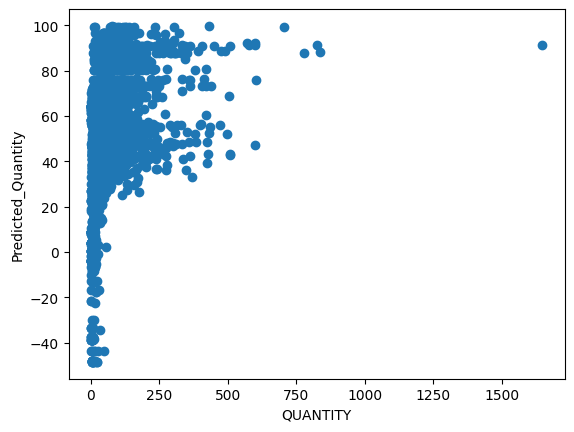

In [129]:
plt.scatter(y_test_prediction_merge['QUANTITY'], y_test_prediction_merge['Predicted_Quantity'])
plt.xlabel('QUANTITY')
plt.ylabel('Predicted_Quantity')
plt.show()

## **Regressie uitkomst**

**Mean Squared Error (MSE)**
\
-kwadrateer elke errorgrootte
\
-Bereken het gemiddelde van alle kwadraten

In [130]:
mean_squared_error(y_test_prediction_merge['QUANTITY'], y_test_prediction_merge['Predicted_Quantity'])

3444.0175363872877

**Mean Absolute Error (MAE)**
\
-verander elke min-errorgrootte in een plus errorgrootte
\
-Bereken het gemiddelde van alle errorgroottes

In [131]:
mean_absolute_error(y_test_prediction_merge['QUANTITY'],y_test_prediction_merge['Predicted_Quantity'])

32.52655660515397